
# 영화 추천 시스템 



# PROBLEM STATEMENT

- 추천시스템은 영화나 노래등을 추천하는데 사용되며, 주로 관심사나 이용 내역을 기반으로 추천한다.
- 이 노트북에서는, Item-based Collaborative Filtering 으로 추천시스템을 구현한다.

- Dataset MovieLens: https://grouplens.org/datasets/movielens/100k/ 


Collaborative Filtering 이라는 용어는 알아두자! (중요) : 사람이 아닌, 아이템 간의 관계를 기반으로 추천 (Item-based Collaborative Filtering
아이템끼리 상관관계를 구할 수 있음 1에 가까워 질수록 강한 비례 관계, -1로 갈 수록 반비례 관계

# STEP #0: LIBRARIES IMPORT


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os

In [13]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-vision/day12')

# STEP #1: IMPORT DATASET

### Movie_Id_Titles.csv 파일을 읽으세요.

In [14]:
movie_titles_df = pd.read_csv('Movie_Id_Titles.csv')

In [15]:
movie_titles_df.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### 'u.data' 파일을 구글드라이브에서 열어보세요.

그러면, 탭으로 구분되어 있고, 맨 위에 컬럼이름이 없습니다.

따라서 컬럼이름을 'user_id', 'item_id', 'rating', 'timestamp' 로 지어주면서 데이터프레임으로 읽어오세요.

read_csv('') tsv형식은 sep=파라미터 사용

In [19]:
# u.data 파일은 tab으로 되어 있음 (tsv형식)
#movies_rating_df =
# 컬럼명이 u.data 파일에는 없으므로 컬럼명도 만들어 준다

movies_rating_df = pd.read_csv('u.data', sep='\t', names=[  'user_id', 'item_id', 'rating', 'timestamp' ])

In [20]:
movies_rating_df.head(2)

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949


In [ ]:
# db에 저장되어 있는 것을 csv로 내보낸 것임


### timestamp 컬럼은 필요없으니, movies_rating_df 에서 아예 제거하시오.

In [23]:
movies_rating_df.drop('timestamp', axis=1, inplace=True)

In [24]:
movies_rating_df.head()


,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


In [25]:
movies_rating_df.describe()

,user_id,item_id,rating
count,100003.000000,100003.000000,100003.000000
mean,462.470876,425.520914,3.529864
std,266.622454,330.797791,1.125704
min,0.000000,1.000000,1.000000
25%,254.000000,175.000000,3.000000
50%,447.000000,322.000000,4.000000
75%,682.000000,631.000000,4.000000
max,943.000000,1682.000000,5.000000


In [ ]:
# 무비 rating에 최대가 5, 최소 1인 것을 확인

In [26]:
movies_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100003 non-null  int64
 1   item_id  100003 non-null  int64
 2   rating   100003 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


### 두개의 데이터프레임을 합치시오.

### 어떻게 합칠지 모양을 잘 보고 합칩니다.

merge() 합치기 on=파라미터 --> (공통컬럼)

```py
pd.merge(movies_rating_df, movie_titles_df, on='item_id')
```


In [42]:
movies_rating_df = pd.merge(movies_rating_df, movie_titles_df, on='item_id')


# STEP #2: VISUALIZE DATASET

### 각 영화 제목별로, 별점에 대한 기본통계치(최대,최소,중앙,표준편차,1/4,3/4 값)를 보여주세요.

### groupby() 사용하기

`movies_rating_df.groupby('title')['rating'].describe()`
___

In [44]:
movies_rating_df.groupby('title')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


In [35]:
movie_df.title.unique()

array(['Star Wars (1977)', 'Empire Strikes Back, The (1980)',
       'Gone with the Wind (1939)', ..., 'Girls Town (1996)',
       'Silence of the Palace, The (Saimt el Qusur) (1994)',
       'Dadetown (1995)'], dtype=object)

### 각 영화별 별점의 평균을 구하고, 이를 ratings_df_mean 에 저장하시오.

In [45]:
movies_rating_df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [46]:
ratings_df_mean = movies_rating_df.groupby('title')['rating'].mean()

### 각 영화별로, 몇개의 데이터가 있는지 구하고, 이를 ratings_df_count 에 저장하시오.

In [51]:
ratings_df_count = movies_rating_df.title.value_counts()

In [73]:
# 또는 그룹바이로 가능
# 정렬은 안해줌
# 단 정렬은 sort_values()까지 해줘야 함
ratings_df_count = movies_rating_df.groupby('title')['rating'].count().sort_values(ascending=False)

### 두 데이터프레임을 합치세요. 

## 두 데이터 프레임 합치기
- pd.merge() 
`pd.merge(ratings_df_count, ratings_df_mean, on='title')`

- pd.concat()
`pd.concat( [ratings_df_count, ratings_df_mean], axis=1)`
row로 데이터를 붙일 때는 axis=파라미터를 생략하거나 axis=0 한다

- join()
데이터프레임['컬럼'].join( 데이터프레임)
`retings_df_count.join( ratings_df_mean)`
단, 시리즈 데이터는 합치는게 안됨


In [68]:
ratings_df_count.head()
#시리즈 
# 이거는 title 컬럼명이 안들어가 있다 (value_counts()를 했을 경우)
# 컬럼명이 없기 때문에 pd.merge()를 하는 경우에 에러가 남

# 참고: dataFrame은 진한 글씨로 컬럼 명이 나오는 것들...


Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64

In [72]:
movies_rating_df.title.value_counts()

Star Wars (1977)                        584
Contact (1997)                          509
Fargo (1996)                            508
Return of the Jedi (1983)               507
Liar Liar (1997)                        485
                                       ... 
Hostile Intentions (1994)                 1
Reluctant Debutante, The (1958)           1
Invitation, The (Zaproszenie) (1986)      1
Coldblooded (1995)                        1
You So Crazy (1994)                       1
Name: title, Length: 1664, dtype: int64

In [56]:
ratings_df_mean.head()
# 이놈도 시리즈

title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64

In [70]:
retings_df_count.join( ratings_df_mean)
# 조인은 시리즈는 안됨

NameError: ignored

Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64

In [74]:
# merge는 같은 컬럼이 있으면 합치는 것이 가능
pd.merge(ratings_df_count, ratings_df_mean, on='title')

,rating_x,rating_y
title,,
Star Wars (1977),584,4.359589
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701
...,...,...
"Man from Down Under, The (1943)",1,1.000000
Marlene Dietrich: Shadow and Light (1996),1,5.000000
Mat' i syn (1997),1,1.000000


In [76]:
# join은 에러가 남 (시리즈는 안됨)
pd.concat( [ratings_df_count, ratings_df_mean])
# 이렇게 하면 row로 붙여 넣기 때문에 axis를 컬럼으로 지정해주면 된다

title
Star Wars (1977)                         584.000000
Contact (1997)                           509.000000
Fargo (1996)                             508.000000
Return of the Jedi (1983)                507.000000
Liar Liar (1997)                         485.000000
                                            ...    
Young Guns II (1990)                       2.772727
Young Poisoner's Handbook, The (1995)      3.341463
Zeus and Roxanne (1997)                    2.166667
unknown                                    3.444444
Á köldum klaka (Cold Fever) (1994)         3.000000
Name: rating, Length: 3328, dtype: float64

In [78]:
# axis=1 파라미터 컬럼으로 붙이기
ratings_mean_count  = pd.concat( [ratings_df_count, ratings_df_mean], axis=1)

### 컬럼명을 확인하면, 합쳐진 컬럼들이 rating, rating 이라고 되어있습니다. 이를 count, mean 으로 컬럼명을 셋팅하세요.

In [79]:
ratings_mean_count.head()

,rating,rating
Star Wars (1977),584,4.359589
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701


In [81]:
# 딕셔너리에서 키 값이 중복이면 마지막 키만 처리함
# 왼쪽에서 오른쪽으로 연산, 위에서 아래로 연산
ratings_mean_count.rename(columns={'rating': 'count', 'rating': 'mean'})


In [83]:
ratings_mean_count.head()

,mean,mean
Star Wars (1977),584,4.359589
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701


In [85]:
# 위와 같이 rating 컬럼명이 같아서 변경이 rename()메소드로 못하면
# 직접 columns 속성을 이용해서 리스트로 저장해주면 됨
ratings_mean_count.columns = ['count', 'mean']

In [86]:
ratings_mean_count.columns

Index(['count', 'mean'], dtype='object')

### mean 으로 히스토그램을 그려보세요.

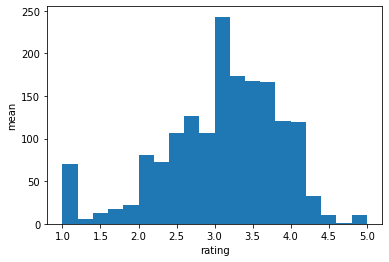

In [93]:
ratings_mean_count['mean'].plot(kind='hist', bins=20)
plt.xlabel('rating')
plt.ylabel('mean')
plt.show()


### count 로 히스토그램을 그려보세요.

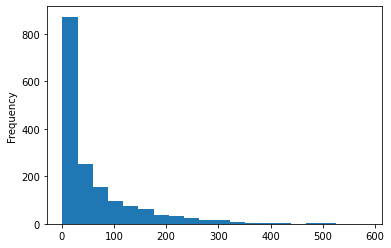

In [94]:
ratings_mean_count['count'].plot(kind='hist', bins=20)
plt.xlabel('')
plt.show()
# 900개의 count는 0-20명 정도가 평가

### 평균점수가 5점인 영화들은 어떤 영화인지 확인하세요.

In [96]:
ratings_mean_count.loc [ratings_mean_count['mean'] == 5, ]

# 1~3명이 평점 5점을 줬을 뿐이여서 신뢰성이 없다

,count,mean
Star Kid (1997),3,5.0
Prefontaine (1997),3,5.0
"Saint of Fort Washington, The (1993)",2,5.0
Santa with Muscles (1996),2,5.0
Aiqing wansui (1994),1,5.0
Someone Else's America (1995),1,5.0
They Made Me a Criminal (1939),1,5.0
"Great Day in Harlem, A (1994)",1,5.0
Entertaining Angels: The Dorothy Day Story (1996),1,5.0
Marlene Dietrich: Shadow and Light (1996),1,5.0


### count 가 가장 많은 것부터 정렬하여 100개까지만 보여주세요.

In [97]:
ratings_mean_count.sort_values(by='count', ascending=False).head(100)

,count,mean
Star Wars (1977),584,4.359589
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701
...,...,...
Babe (1995),219,3.995434
Volcano (1997),219,2.808219
To Kill a Mockingbird (1962),219,4.292237
Aladdin (1992),219,3.812785


In [ ]:
#영화 제목만 볼려고 하면 index 속성 이용

In [98]:
ratings_mean_count.sort_values(by='count', ascending=False).head(100).index

Index(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)',
       'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)',
       'Pulp Fiction (1994)', 'Twelve Monkeys (1995)',
       'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)',
       'Chasing Amy (1997)', 'Rock, The (1996)',
       'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)',
       'Back to the Future (1985)', 'Titanic (1997)',
       'Mission: Impossible (1996)', 'Fugitive, The (1993)',
       'Indiana Jones and the Last Crusade (1989)',
       'Willy Wonka and the Chocolate Factory (1971)',
       'Princess Bride, The (1987)', 'Forrest Gump (1994)',
       'Monty Python and the Holy Grail (1974)', 'Saint, The (1997)',
       'Full Monty, The (1997)', 'Men in Black (1997)',
       'Terminator, Th

# STEP #3: 영화 하나에 대한, ITEM-BASED COLLABORATIVE FILTERING 수행!

In [99]:
# movies_rating_df 를 가지고 아래 피봇테이블 합니다.
movies_rating_df.head()

,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
1,290,50,5,Star Wars (1977)
2,79,50,4,Star Wars (1977)
3,2,50,5,Star Wars (1977)
4,8,50,5,Star Wars (1977)


### 피봇 테이블을 하여, 콜라보레이티브 필터링 포맷으로 변경

In [ ]:
#피봇 테이블
# 피봇팅 한다. 즉 컬럼의 값을 행으로 만드는것. (unique하게 만들어 준다)
# 여러개의 숫자 데이터를 합치거나 평균을 내거나, 표준편차를 연산해 줌
# 한 컬럼의 값이 겹칠 때 그 컬럼을 합치면서 이와 관련된 다른 컬럼의 값을 더하거나 해줌

In [101]:
movies_rating_df.loc [ movies_rating_df['user_id'] == 0, ]
# 이 사람은 rating성향이

,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
584,0,172,5,"Empire Strikes Back, The (1980)"
952,0,133,1,Gone with the Wind (1939)


In [102]:
movies_rating_df.loc [ movies_rating_df['user_id'] == 1, ]

,user_id,item_id,rating,title
257,1,50,5,Star Wars (1977)
926,1,172,5,"Empire Strikes Back, The (1980)"
999,1,133,4,Gone with the Wind (1939)
1138,1,242,5,Kolya (1996)
1557,1,51,4,Legends of the Fall (1994)
...,...,...,...,...
97678,1,18,4,"White Balloon, The (1995)"
98213,1,247,1,Turbo: A Power Rangers Movie (1997)
98264,1,35,1,Free Willy 2: The Adventure Home (1995)
98513,1,130,3,Kansas City (1996)


In [ ]:
# user_id를 하나로 합쳐서 index로 나오게 하고 컬럼은 영화제목으로 나오게 한다

- 피봇테이블 pivot_table( index=, columns=,  values= )
index= 파라미터: 특정컬럼을 index (row)(왼쪽)를 만들어준다 
- columns=파라미터: 특정컬럼을 말그대로 컬럼으로 만들어 준다. 컬럼에서 여기서는 title컬럼에서 중복되는 문자열들이 컬럼이 된다. 즉 unique()같은 효과이다
- values=파라미터: 이제 인덱스와, 컬럼이 셋팅이 되었고 그 안에 어떤내용으로 넣을 지 결정, 여기에서는 'rating' 타이틀을 이용했고, rating값들이 들어가진다

예: 0번 유저은 영화를 3개밖에 rating을 안했기 때문에 컬럼에는 NaN이 들어가지고 별점을 준 영화 3개에만 rating값이 들어간다

```py
movies_rating_df.pivot_table(index='user_id', columns='title', values='rating')
```


In [103]:
userid_movieTitle_matrix = movies_rating_df.pivot_table(index='user_id', columns='title', values='rating')

In [104]:
userid_movieTitle_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# 특정 유저아이디를 볼 때 (user_id)
userid_movieTitle_matrix.loc[26, ]

title
'Til There Was You (1997)               NaN
1-900 (1994)                            NaN
101 Dalmatians (1996)                   NaN
12 Angry Men (1957)                     NaN
187 (1997)                              NaN
                                         ..
Young Guns II (1990)                    NaN
Young Poisoner's Handbook, The (1995)   NaN
Zeus and Roxanne (1997)                 NaN
unknown                                 NaN
Á köldum klaka (Cold Fever) (1994)      NaN
Name: 26, Length: 1664, dtype: float64

### 전체 영화와, 타이타닉 영화의 상관관계 분석을 하면, 타이타닉을 본 사람들에게 상관계수가 높은 영화를 추천하면 된다. corrwith 함수를 이용한다.

In [109]:
userid_movieTitle_matrix.shape

(944, 1664)

In [ ]:
# 컬럼과 컬럼의 관계를 상관관계 (그래서 컬럼을 title로 만듬)
# userid_movieTitle_matrix.corrwith('')

In [110]:
# 타이타닉 영화에 대해서, 유저가 준 점수를 확인
userid_movieTitle_matrix['Titanic (1997)']

user_id
0      NaN
1      NaN
2      5.0
3      NaN
4      NaN
      ... 
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 944, dtype: float64

In [111]:
# 컬럼들과 특정컬럼의 상관관계를 분석할 때 
userid_movieTitle_matrix.corrwith(  userid_movieTitle_matrix['Titanic (1997)']  )

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)               -0.062017
1-900 (1994)                                  NaN
101 Dalmatians (1996)                    0.120113
12 Angry Men (1957)                      0.077700
187 (1997)                               0.315654
                                           ...   
Young Guns II (1990)                     0.317274
Young Poisoner's Handbook, The (1995)    0.356783
Zeus and Roxanne (1997)                       NaN
unknown                                       NaN
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

In [112]:
# 위의 경고를 무시하고 진행하라는 코드
np.seterr(divide='ignore', invalid= 'ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [114]:
titanic_series = userid_movieTitle_matrix.corrwith(  userid_movieTitle_matrix['Titanic (1997)']  )

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


In [115]:
titanic_series

title
'Til There Was You (1997)               -0.062017
1-900 (1994)                                  NaN
101 Dalmatians (1996)                    0.120113
12 Angry Men (1957)                      0.077700
187 (1997)                               0.315654
                                           ...   
Young Guns II (1990)                     0.317274
Young Poisoner's Handbook, The (1995)    0.356783
Zeus and Roxanne (1997)                       NaN
unknown                                       NaN
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

In [116]:
pd.DataFrame(data= titanic_series, columns=['Correlation'] )

,Correlation
title,
'Til There Was You (1997),-0.062017
1-900 (1994),NaN
101 Dalmatians (1996),0.120113
12 Angry Men (1957),0.077700
187 (1997),0.315654
...,...
Young Guns II (1990),0.317274
"Young Poisoner's Handbook, The (1995)",0.356783
Zeus and Roxanne (1997),NaN


In [117]:
titanic_correlations =  pd.DataFrame(data= titanic_series, columns=['Correlation'])

In [118]:
titanic_correlations

,Correlation
title,
'Til There Was You (1997),-0.062017
1-900 (1994),NaN
101 Dalmatians (1996),0.120113
12 Angry Men (1957),0.077700
187 (1997),0.315654
...,...
Young Guns II (1990),0.317274
"Young Poisoner's Handbook, The (1995)",0.356783
Zeus and Roxanne (1997),NaN


In [119]:
# count컬럼을 만들어서 영화에 평가한 수를 넣어줘야한다 
# 그래야 신뢰도가 있음

In [121]:
ratings_mean_count['count']
# 이 컬럼을 titanic_correlations 데이터프레임에 붙여준다

Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: count, Length: 1664, dtype: int64

join()으로 합치기

In [124]:
titanic_correlations = titanic_correlations.join( ratings_mean_count['count'] )

In [ ]:
# NaN 제거

In [126]:
titanic_correlations.dropna(inplace=True)

In [128]:
titanic_correlations.isna().sum()

Correlation    0
count          0
dtype: int64

In [ ]:
# 정렬하기 Correlation 컬럼으로 정렬

In [129]:
titanic_correlations.sort_values(by='Correlation', ascending=False)

,Correlation,count
title,,
Nadja (1994),1.0,8
"Pest, The (1997)",1.0,8
"Savage Nights (Nuits fauves, Les) (1992)",1.0,3
For Ever Mozart (1996),1.0,3
"Jerky Boys, The (1994)",1.0,3
...,...,...
Pather Panchali (1955),-1.0,8
Angel Baby (1995),-1.0,4
Blood Beach (1981),-1.0,6


In [ ]:
# 정렬은 잘 되었는데 count가 너무 적음, 8명~ 3명은 적음
# 신뢰, 정확성을 높이기 위해서
# 영화를 본 사람이 적어도 80명 이상의 사람들의 데이터를 가지고
# 영화를 추천해 주는 것이 신뢰도상 좋을 것 같다

In [136]:
titanic_correlations_above80 = titanic_correlations.loc [ titanic_correlations['count'] >= 80, ]

In [137]:
titanic_correlations_above80

,Correlation,count
title,,
101 Dalmatians (1996),0.120113,109
12 Angry Men (1957),0.077700,125
2 Days in the Valley (1996),0.017295,93
2001: A Space Odyssey (1968),-0.042024,259
Absolute Power (1997),0.327028,127
...,...,...
Willy Wonka and the Chocolate Factory (1971),-0.115819,326
"Wizard of Oz, The (1939)",0.155928,246
"Wrong Trousers, The (1993)",0.227949,118


In [ ]:
# 다시 정렬해서 상위 5개 보기

In [140]:
titanic_correlations_above80.sort_values(by= 'Correlation', ascending=False).head(6)

,Correlation,count
title,,
Titanic (1997),1.000000,350
"River Wild, The (1994)",0.497600,146
"Abyss, The (1989)",0.472103,151
Bram Stoker's Dracula (1992),0.443560,120
True Lies (1994),0.435104,208
William Shakespeare's Romeo and Juliet (1996),0.430243,106


### 실습. star wars 를 본 사람들에게 영화를 추천할 것입니다. 5개의 추천 영화 제목을 찾으세요.

힌트 : 먼저 star wars 의 정확한 이름을 검색해서 찾으세요. 그리고 나서 스타워즈를 본 유저의 데이터를 가져와서, 위와 같이 상관관계분석을 합니다.

In [148]:
userid_movieTitle_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# to_frame()을 하면 데이터 프레임으로 변환해서 보여줌
movie_titles_df['title'].str.lower().to_frame()

,title
0,toy story (1995)
1,goldeneye (1995)
2,four rooms (1995)
3,get shorty (1995)
4,copycat (1995)
...,...
1677,mat' i syn (1997)
1678,b. monkey (1998)
1679,sliding doors (1998)
1680,you so crazy (1994)


In [174]:
my_star_wars = movie_titles_df['title'].str.lower().to_frame()['title'].str.contains('star wars')

In [175]:
my_star_wars

0       False
1       False
2       False
3       False
4       False
        ...  
1677    False
1678    False
1679    False
1680    False
1681    False
Name: title, Length: 1682, dtype: bool

In [185]:
userid_movieTitle_matrix.loc [my_star_wars,  ]

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN


In [188]:
star_core_series = userid_movieTitle_matrix.corrwith( userid_movieTitle_matrix['Star Wars (1977)'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


In [187]:
starwars_correlations


title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

In [193]:
 stars_correlations = pd.DataFrame(data= starwars_correlations, columns=['Correlation'])

In [191]:
ratings_mean_count['count']

Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: count, Length: 1664, dtype: int64

In [195]:
# join()메소드 , index값이 같은 경우에 알아서 맞춰서 넣어준다 
# count컬럼 데이터가 없으면 의미가 없음 그래서 join 시켜줌
stars_correlations = stars_correlations.join( ratings_mean_count['count'] )

In [196]:
stars_correlations.head()

,Correlation,count
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [197]:
#전체를 다 corr()
userid_movieTitle_matrix.corr()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.0,NaN,-1.000000,-0.500000,-0.500000,0.522233,NaN,-0.426401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981981,0.866025,NaN,NaN,0.571772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.867722,NaN,NaN,NaN,-0.034483,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,-0.132453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.981981,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981981,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.188982,NaN,NaN,0.995871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),-1.0,NaN,1.000000,-0.049890,0.269191,0.048973,0.266928,-0.043407,NaN,0.111111,0.522233,NaN,1.0,NaN,NaN,0.398783,0.236350,-0.147491,0.094964,NaN,0.195058,-0.094832,NaN,0.242363,-0.135467,-0.263889,0.000000,0.192703,NaN,0.531490,NaN,NaN,0.221943,0.750000,-0.645497,0.132116,0.385118,0.326669,0.883883,-0.5,...,NaN,0.000000,NaN,NaN,NaN,-0.219265,NaN,0.0,0.257404,0.105261,NaN,NaN,0.575224,0.880705,-0.101371,1.0,1.000000,0.714832,1.000000,NaN,0.366592,0.219445,NaN,0.969458,NaN,-1.000000,NaN,NaN,-0.002382,0.042025,NaN,-1.000000,NaN,0.158840,0.119234,0.680414,0.000000,0.707107,NaN,NaN
12 Angry Men (1957),-0.5,NaN,-0.049890,1.000000,0.666667,0.256625,0.274772,0.178848,NaN,0.457176,0.635698,NaN,NaN,NaN,1.0,-0.163455,0.045374,-0.243775,-0.045596,1.0,0.000000,0.867722,NaN,0.020207,0.343750,0.450000,0.794719,0.266966,1.000000,0.420304,NaN,-0.097129,0.228031,0.000000,0.042640,0.651377,0.030291,-0.226871,NaN,NaN,...,-0.5,0.677908,NaN,NaN,0.707107,0.264693,NaN,0.0,0.265786,0.149164

In [199]:
# 전체 무비에서 corr() 상관관계를 분석하는 min_periods= 파라미터를 지정하면
# 80 이하는 NaN으로 표시
movie_correlations = userid_movieTitle_matrix.corr(min_periods=80)

# STEP#4: 전체 데이터셋에 대한 ITEM-BASED COLLABORATIVE FILTER 를 만들자!

### 나의 별점 정보를 가지고, 영화를 추천해 달라고 할 것이다! 

내 영화 별점 정보는 My_Ratings.csv 파일에 있다. 

In [200]:
myRatings = pd.read_csv('My_Ratings.csv')
 

In [201]:
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [203]:
movie_title = myRatings.iloc[0, 0]

In [204]:
movie_title

'Liar Liar (1997)'

In [205]:
movie_correlations[movie_title]
# 여기에서 수치가 없는 것은 dropna()하면 됨

title
'Til There Was You (1997)               NaN
1-900 (1994)                            NaN
101 Dalmatians (1996)                   NaN
12 Angry Men (1957)                     NaN
187 (1997)                              NaN
                                         ..
Young Guns II (1990)                    NaN
Young Poisoner's Handbook, The (1995)   NaN
Zeus and Roxanne (1997)                 NaN
unknown                                 NaN
Á köldum klaka (Cold Fever) (1994)      NaN
Name: Liar Liar (1997), Length: 1664, dtype: float64

In [210]:
#dropna()와 정렬과 
movie_correlations[movie_title].dropna().sort_values(ascending=False)

title
Liar Liar (1997)                                                               1.000000
Con Air (1997)                                                                 0.469828
Pretty Woman (1990)                                                            0.469790
Michael (1996)                                                                 0.442022
Indiana Jones and the Last Crusade (1989)                                      0.414427
                                                                                 ...   
Leaving Las Vegas (1995)                                                      -0.137398
Fantasia (1940)                                                               -0.147819
This Is Spinal Tap (1984)                                                     -0.158213
Brazil (1985)                                                                 -0.161261
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)   -0.238092
Name: Liar Liar (1997), Le

In [211]:
# to_frame()으로 데이터프레임으로 만들기
recom_movie1 = movie_correlations[movie_title].dropna().sort_values(ascending=False).to_frame()

In [213]:
recom_movie1.head(6)

,Liar Liar (1997)
title,
Liar Liar (1997),1.000000
Con Air (1997),0.469828
Pretty Woman (1990),0.469790
Michael (1996),0.442022
Indiana Jones and the Last Crusade (1989),0.414427
Top Gun (1986),0.405720


In [ ]:
#위의 데이터프레임의 컬럶 이름을 Correlation으로 바꿈

In [217]:

recom_movie1.rename( columns = {'Liar Liar (1997)': 'Correlation'}, inplace=True)

In [218]:
recom_movie1

,Correlation
title,
Liar Liar (1997),1.000000
Con Air (1997),0.469828
Pretty Woman (1990),0.469790
Michael (1996),0.442022
Indiana Jones and the Last Crusade (1989),0.414427
...,...
Leaving Las Vegas (1995),-0.137398
Fantasia (1940),-0.147819
This Is Spinal Tap (1984),-0.158213


In [ ]:
#가중치 계산을 해서 새로운 컬럼을 만듬
# correlation값 X rating값을 해준다

In [220]:
recom_movie1['Weight'] = recom_movie1['Correlation'] * myRatings['Ratings'] [0]

In [221]:
recom_movie1

,Correlation,Weight
title,,
Liar Liar (1997),1.000000,5.000000
Con Air (1997),0.469828,2.349141
Pretty Woman (1990),0.469790,2.348951
Michael (1996),0.442022,2.210110
Indiana Jones and the Last Crusade (1989),0.414427,2.072136
...,...,...
Leaving Las Vegas (1995),-0.137398,-0.686991
Fantasia (1940),-0.147819,-0.739094
This Is Spinal Tap (1984),-0.158213,-0.791064


## 이제는 두번째 영화인, 스타워즈도 추천영화 똑같이 가져오자.

In [223]:
my_title2 = myRatings.iloc[1, 0]

In [224]:
my_title2

'Star Wars (1977)'

In [230]:
starwars_corr_2 =movie_correlations[my_title2].dropna().sort_values(ascending=False).to_frame()

In [233]:
starwars_corr_2 
# 마찬가지로 타이틀 바꾸기
starwars_corr_2.rename(columns={ 	'Star Wars (1977)': 'Correlation'}, inplace=True)

In [234]:
#추천 계산하기
starwars_corr_2

,Correlation
title,
Star Wars (1977),1.000000
"Empire Strikes Back, The (1980)",0.748353
Return of the Jedi (1983),0.672556
Raiders of the Lost Ark (1981),0.536117
Austin Powers: International Man of Mystery (1997),0.377433
...,...
Little Women (1994),-0.121053
Dirty Dancing (1987),-0.156920
G.I. Jane (1997),-0.176734


In [241]:
starwars_corr_2['weihgt'] = starwars_corr_2['Correlation'] * myRatings['Ratings'][1]

In [242]:
starwars_corr_2

,Correlation,weihgt
title,,
Star Wars (1977),1.000000,1.000000
"Empire Strikes Back, The (1980)",0.748353,0.748353
Return of the Jedi (1983),0.672556,0.672556
Raiders of the Lost Ark (1981),0.536117,0.536117
Austin Powers: International Man of Mystery (1997),0.377433,0.377433
...,...,...
Little Women (1994),-0.121053,-0.121053
Dirty Dancing (1987),-0.156920,-0.156920
G.I. Jane (1997),-0.176734,-0.176734


## 위의 추천영화 작업을 자동화 하기 위한 파이프라인을 만드시오. 

힌트 : 반복문을 사용하여 비슷한영화에 대한 데이터프레임을 만들고, 이를 아래 빈 데이터프레임에 계속하여 추가하시오. 반복문이 끝나면, 아래 데이터프레임을 wegiht 컬럼으로 정렬하면 됩니다.

In [243]:
similar_movies_list = pd.DataFrame()

In [251]:
for i in np.arange(0, len(myRatings)):
  movie_title = myRatings['Movie Name'][i]
  similar_movies = movie_correlations[ movie_title ].dropna().sort_values(ascending=False).to_frame() 
  similar_movies.columns = ['Correlation']
  similar_movies['Weight'] = similar_movies['Correlation'] * myRatings['Ratings'][i]
  similar_movies_list = similar_movies_list.append(similar_movies)

In [252]:
similar_movies_list.sort_values('Weight', ascending=False).head(12)

,Correlation,Weight
title,,
Liar Liar (1997),1.000000,5.000000
Con Air (1997),0.469828,2.349141
Pretty Woman (1990),0.469790,2.348951
Michael (1996),0.442022,2.210110
Indiana Jones and the Last Crusade (1989),0.414427,2.072136
Top Gun (1986),0.405720,2.028602
G.I. Jane (1997),0.397931,1.989656
Multiplicity (1996),0.396860,1.984302
Grumpier Old Men (1995),0.390699,1.953494
